In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# standard python
import numpy as np
import scipy
from scipy import stats
#import pathlib

import os
# plotting, especially for jupyter notebooks
import matplotlib
#matplotlib.rcParams['text.usetex'] = True # breaks for some endpoint labels
from matplotlib import pyplot as plt
from IPython.display import Image
import pandas as pd
# tensorflow
import tensorflow as tf
#tf.enable_eager_execution() # needed for tf version 1 or it stages operations but does not do them
from tensorflow import keras
from tensorflow.keras import layers, regularizers
tf.keras.backend.clear_session()  # For easy reset of notebook state.
# local routines
#from chemdataprep import load_PDBs,load_countsfromPDB,load_diametersfromPDB,find_chemnames
from toxmathandler import load_tscores

#checkpoint_path = "/home2/ajgreen4/Read-Across_w_GAN/Models/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

print("tensorflow version",tf.__version__,". Executing eagerly?",tf.executing_eagerly())
print("Number of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-11-27 17:56:29.199471: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 17:56:30.688762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 17:56:30.688797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 17:56:30.748524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 17:56:31.375894: I tensorflow/core/platform/cpu_feature_g

2023-11-27 17:56:39.682055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version 2.14.0 . Executing eagerly? True
Number of GPUs:  0


In [4]:
import chemdataprep as CP
import toxmathandler
#!pip install scipy 
import scipy.io

In [5]:
qm7_data = scipy.io.loadmat('qm7.mat')



In [6]:

# Print the dimensions of each array
for key in ['X', 'R', 'Z', 'T', 'P']:
    array = qm7_data.get(key)
    if array is not None:
        print(f"Dimensions of {key}: {array.shape}")
    else:
        print(f"{key} not found in the dataset")


Dimensions of X: (7165, 23, 23)
Dimensions of R: (7165, 23, 3)
Dimensions of Z: (7165, 23)
Dimensions of T: (1, 7165)
Dimensions of P: (5, 1433)


Z: 7165\*23\*23 coulomb matrices

R: cartesian coordinates of each atom in the molecules 

Z: atomic charges

<span style='color:#f44336'>T: Atomization energies \(unit: kcal/mol\)</span>

P: cross validation splits 



results published by moleculenet for qm7 data \(MAE \(Kcal/mol\)

tf\_regression: 8.56

kernal ridge regression: 10.80

ANI: 2.77

deep tensor neural network: 6.63

grap convolution regression: 76.10



In [7]:
# Get the atomic numbers array
# Z is numpy array that might be multi-dimensional so its better to convert it to one-dimensional array
atomic_numbers = qm7_data['Z']
all_atomic_numbers = atomic_numbers.flatten()

# Find atomic numbers
unique_atomic_numbers = set(all_atomic_numbers)
unique_atomic_numbers.discard(0)  # Remove 0 if it's not a valid atomic number

# Print unique atomic numbers
print("atomic numbers:", unique_atomic_numbers)

atomic numbers: {1.0, 6.0, 7.0, 8.0, 16.0}


In [8]:
def atomic_number_to_symbol(atomic_number):
    periodic_table = {
        1: 'H', 6: 'C', 7: 'N', 8: 'O', 16: 'S'
    }
    return periodic_table.get(atomic_number, 'Unknown')

# Convert atomic numbers to element symbols
unique_elements = {atomic_number_to_symbol(int(num)) for num in unique_atomic_numbers}
import numpy as np

Z = qm7_data['Z']
R = qm7_data['R']
mollist = []

for mol_idx in range(Z.shape[0]):
    molecule = []
    for atom_idx in range(Z.shape[1]):
        atomic_number = Z[mol_idx, atom_idx]
        if atomic_number != 0:  # Assuming 0 means no atom present
            atom_type = atomic_number_to_symbol(atomic_number)
            # Ensure coordinates are a NumPy array
            coordinates = np.array(R[mol_idx, atom_idx, :])
            molecule.append((atom_type, coordinates))
    mollist.append(molecule)


In [19]:
print(mollist)

In [9]:
mollist[0]

[('C', array([ 1.886438  , -0.00464873, -0.00823921], dtype=float32)),
 ('H', array([ 3.9499245 , -0.00459203,  0.00782347], dtype=float32)),
 ('H', array([1.1976895 , 1.9404842 , 0.00782347], dtype=float32)),
 ('H', array([ 1.1849339 , -0.99726516,  1.6593875 ], dtype=float32)),
 ('H', array([ 1.2119948, -0.9589793, -1.710958 ], dtype=float32))]

In [26]:
[set([a[0] for a in mol]) for mol in mollist]

[{'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'O'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'N'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'O'},
 {'C', 'H', 'N', 'O'},
 {'C', 'H'},
 {'C', 'H', 'N', 'O'},
 {'C', 'H', 'N', 'O'},
 {'C', 'H', 'N', 'O'},
 {'C', 'H', 'N', 'O'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H'},
 {'C', 'H', '

In [9]:

def speciesmap(atom_type):
    atom_to_number = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'S': 16}
    #print(atom_type)
    return np.array([atom_to_number.get(atom_type, 0)])  # Returns 0 if atom type is not recognized


In [9]:
from chemdataprep import load_qm7_data
ws, vs, Natoms, Nviews = load_qm7_data(mollist, speciesmap, setNatoms=None, setNviews=None, carbonbased=False, verbose=1)


7165 molecules will be processed.
Species occurring = {'H', 'O', 'N', 'C', 'S'}
Using max Natoms = 23
rotation error 1.148946892670453e-08
rotation error 2.1881981300267542e-06
rotation error 1.1489468698865879e-08
rotation error 6.487544748972112e-08
rotation error 4.950082864644407e-08
rotation error 5.647219680394401e-08
rotation error 2.530150017666664e-08
rotation error 5.647219680394261e-08
rotation error 8.994059659636644e-08
rotation error 5.212299370224517e-08
rotation error 2.5301500348397982e-08
rotation error 8.721654572281707e-08
rotation error 3.713179484542796e-08
rotation error 5.363828265204944e-08
rotation error 3.745392393018379e-08
rotation error 5.363828266129694e-08
rotation error 3.259678058408026e-08
rotation error 3.7453923596811835e-08
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.1415926535897

rotation error 3.740453328649404e-08
rotation error 3.7883914451229694e-08
rotation error 3.6758848421675814e-08
structuretoviews: WARNING: cosofangle <= -1: -1.0000000152277093
colinear 3.141592653589793
rotation error 1.4383985737075857e-08
rotation error 3.740453314680952e-08
rotation error 4.4746817124625024e-08
rotation error 3.788391430191755e-08
rotation error 1.4383985718902601e-08
rotation error 2.1358619251693336e-08
rotation error 1.628102694533999e-08
rotation error 1.910156321689944e-08
rotation error 2.1358619405441744e-08
rotation error 9.006063303867494e-08
rotation error 2.9198647119487946e-08
rotation error 1.62810269330619e-08
rotation error 6.26757776136255e-08
rotation error 4.713925321928315e-08
rotation error 3.9455095555705394e-08
rotation error 4.788591949471562e-08
rotation error 3.460799146388125e-08
rotation error 4.713925297027718e-08
rotation error 1.2739545427471339e-08
rotation error 3.9455095747184576e-08
rotation error 4.788591948885442e-08
rotation er

rotation error 2.7063066726271546e-08
rotation error 5.542918297017516e-08
rotation error 8.252949681519364e-08
rotation error 3.299284193323809e-08
rotation error 1.1378723924557377e-07
rotation error 1.3052384597906808e-07
rotation error 8.252949683349365e-08
rotation error 6.188242686706293e-08
rotation error 1.3830550040776077e-08
rotation error 1.137872387773201e-07
rotation error 1.0346215192754423e-08
rotation error 1.305238459571552e-07
rotation error 1.658135592312433e-07
rotation error 1.7171735314536164e-08
rotation error 7.062859068868656e-08
rotation error 5.810438718164641e-08
rotation error 4.975946891434177e-08
rotation error 7.305801012138039e-08
rotation error 8.826239812302844e-08
rotation error 7.062859117330912e-08
rotation error 5.8104387057184144e-08
rotation error 3.0557555129589e-08
rotation error 6.427830738881e-08
rotation error 4.975946932963172e-08
rotation error 5.868781727113496e-08
rotation error 9.03829556187425e-08
rotation error 3.1604899758966265e-08

rotation error 6.716045088599193e-08
rotation error 4.1567627029437494e-08
rotation error 1.254796430685248e-08
rotation error 6.533104208833095e-08
rotation error 3.01857311490948e-08
rotation error 6.716045098360604e-08
rotation error 9.161840887938735e-08
rotation error 4.1567626697374665e-08
rotation error 6.533104204602161e-08
rotation error 1.1205194659004607e-07
rotation error 1.9786748503444143e-08
rotation error 4.8316737365443485e-08
rotation error 1.3334075340471666e-07
rotation error 2.738743125275424e-08
rotation error 1.9786748464556784e-08
rotation error 4.8316737372829785e-08
rotation error 6.993151692588282e-08
rotation error 2.8206803379228382e-08
rotation error 3.469197967598236e-08
rotation error 9.509321578882491e-08
rotation error 4.36279721828847e-08
rotation error 1.1883041126475859e-08
rotation error 3.848509567904993e-08
rotation error 2.1418131769092793e-08
rotation error 3.469197967975144e-08
rotation error 5.492259066040911e-08
rotation error 9.509321559348

rotation error 2.820024695401611e-08
rotation error 1.9895332817301184e-06
rotation error 4.562997553399419e-06
rotation error 1.3446927295819632e-08
rotation error 1.2414854686856336e-08
rotation error 7.903251914794928e-08
rotation error 2.820024723013967e-08
rotation error 3.6858387009384535e-08
rotation error 1.4662701334491887e-08
rotation error 4.562997554175134e-06
rotation error 6.583390459538061e-08
rotation error 4.4726565322354466e-08
rotation error 1.0480670222497012e-08
rotation error 1.2311598237673204e-08
rotation error 6.583390466913908e-08
rotation error 3.7024424117711776e-08
rotation error 4.472656574558335e-08
rotation error 1.0480670026007588e-08
rotation error 1.1628575628186222e-07
rotation error 1.3627561966876324e-08
rotation error 1.710416632620461e-08
rotation error 1.2311598401645208e-08
rotation error 1.0472138296962691e-07
rotation error 6.205302471878754e-08
rotation error 5.292898228625935e-08
rotation error 1.1591102282890698e-08
rotation error 1.413510

rotation error 2.4893814344069466e-08
rotation error 2.9593837624280727e-08
rotation error 3.70866077126377e-08
rotation error 1.7017831053276238e-06
rotation error 1.655745780030649e-08
rotation error 3.647939863548598e-06
rotation error 4.091653435695399e-08
rotation error 9.098189908335829e-07
rotation error 3.3045099097931896e-08
rotation error 1.2012617441422972e-08
rotation error 1.87767731124154e-08
rotation error 6.877528352366678e-08
structuretoviews: WARNING: cosofangle <= -1: -1.0000000152299724
colinear 3.141592653589793
rotation error 6.877528325876864e-08
rotation error 7.18938086233207e-08
rotation error 3.304509893712016e-08
rotation error 1.2012617321604743e-08
rotation error 7.641143729620916e-08
rotation error 1.8776773112420817e-08
rotation error 1.7426688665981094e-07
rotation error 7.755791052918238e-08
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
rotation 

rotation error 3.7156643159127066e-08
rotation error 9.67100295236335e-08
rotation error 1.926357274478211e-08
rotation error 6.665465891988178e-08
rotation error 7.762643546458377e-08
rotation error 9.671002946889143e-08
rotation error 1.9263572603155706e-08
rotation error 6.665465932017446e-08
rotation error 7.762643553581085e-08
rotation error 6.29388377512438e-08
rotation error 4.862026756827748e-08
rotation error 1.3966747886620116e-08
rotation error 1.3562762602391345e-08
rotation error 6.293883781882718e-08
rotation error 2.5023380769474e-08
rotation error 3.126123601399764e-08
rotation error 4.862026756633103e-08
rotation error 1.356276240041706e-08
rotation error 1.154302412924414e-08
rotation error 2.2230198382127567e-08
rotation error 2.4276744730583265e-08
rotation error 8.6316768332465e-08
rotation error 2.6945642438352448e-08
rotation error 8.525349562494793e-08
rotation error 2.4276744599091022e-08
rotation error 8.631676833036454e-08
rotation error 2.6945642174765185e-0

In [11]:
from chemdataprep import structuretoviews
wvlist=structuretoviews(mollist[10])

rotation error 1.38356174541629e-08
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
structuretoviews: WARNING: cosofangle <= -1: -1.0
colinear 3.141592653589793
rotation error 4.819505249739287e-08
rotation error 6.783948885698823e-08
rotation error 1.3835617328310954e-08
structuretoviews: WARNING: cosofangle >= 1: 1.0
colinear 0.0
structuretoviews: WARNING: cosofangle >= 1: 1.0
colinear 0.0


##### split data into training and testing



In [10]:
from chemdataprep import chemicaldiameter
#delist=[chemicaldiameter(x) for x in mollist]
#labels=np.array(delist)
T=qm7_data['T']
T_reshaped = T.reshape((7165,))
print(type(T_reshaped))
T_reshaped.shape


<class 'numpy.ndarray'>


(7165,)

In [11]:
from sklearn.model_selection import train_test_split
Z = qm7_data['Z']
R = qm7_data['R']

# Split the dataset into training and testing sets
#usual routine, training to testing ratio is 80:20
Z_train, Z_test, R_train, R_test, T_train, T_test = train_test_split(Z, R,T_reshaped, test_size=0.2, random_state=42)

def atomic_number_to_symbol(atomic_number):
    periodic_table = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 16: 'S'}
    return periodic_table.get(atomic_number, 'Unknown')
def convert_to_mollist1(Z_data, R_data):
    mollist1 = []
    for mol_idx in range(Z_data.shape[0]):
        molecule = []
        for atom_idx in range(Z_data.shape[1]):
            atomic_number = Z_data[mol_idx, atom_idx]
            if atomic_number != 0:  # Assuming 0 means no atom present
                atom_type = atomic_number_to_symbol(atomic_number)
                coordinates = np.array(R_data[mol_idx, atom_idx, :])
                molecule.append((atom_type, coordinates))
        mollist1.append(molecule)
    return mollist1

# Convert training and testing data to mollist format
qm7_train = convert_to_mollist1(Z_train, R_train)
qm7_test = convert_to_mollist1(Z_test, R_test)
qm7_labels_train = T_train
qm7_labels_test = T_test

#qm7_labels_train = [chemicaldiameter(x) for x in qm7_train]
#qm7_labels_test = [chemicaldiameter(x) for x in qm7_test]




In [14]:
length_of_qm7_labels_train = len(qm7_labels_train)
print(len(qm7_labels_train))
length_of_qm7_labels_test = len(qm7_labels_test)
print(len(qm7_labels_test))
len(T_reshaped)


5732
1433


7165

In [13]:
qm7_labels_train.shape

(5732,)

In [62]:
print(np.array(qm7_labels_train).shape)
print(np.array(qm7_labels_test).shape)

(5732,)
(1433,)


In [12]:
ws_qm7_train, vs_qm7_train, Natoms_train, Nviews_train = load_qm7_data(qm7_train, speciesmap, setNatoms=None, setNviews=None, carbonbased=False, verbose=1)
qm7G_train=[ws_qm7_train, vs_qm7_train]
ws_qm7_test, vs_qm7_test, Natoms_test, Nviews_test = load_qm7_data(qm7_test, speciesmap, setNatoms=None, setNviews=None, carbonbased=False, verbose=1)
qm7G_test=[ws_qm7_test, vs_qm7_test]


NameError: name 'load_qm7_data' is not defined

In [13]:
labelsG_train = qm7_labels_train
labelsG_test = qm7_labels_test
Ntoxicity = 1
ws_train, vs_train = ws_qm7_train, vs_qm7_train
ws_test, vs_test = ws_qm7_test, vs_qm7_test
dataG_train=[ws_train,vs_train]
dataG_test=[ws_test,vs_test]

### **Neural Network Code**

#### **constructor routines**



In [4]:
# generic dense NN
def multiDense(Nin,Nout,Nhidden,widthhidden=None,kernel_regularizer=None):
    """Construct a basic NN with some dense layers.
    
    :parameter Nin: The number of inputs
    :type Nin: int
    :parameter Nout: The number of outputs
    :type Nout: int
    :parameter Nhidden: The number of hidden layers.
    :type Nhidden: int
    :parameter widthhidden: The width of each hidden layer.
        If left at None, Nin + Nout will be used.
    :parameter kernel_regularizer: the regularizer to use, such as regularizers.l2(0.001)
    :type kernel_regularizer: tensorflow.keras.regularizers.xxx
    :returns: The NN model
    :rtype: keras.Model
    
    """
    if widthhidden is None:
        widthhidden = Nin + Nout
    x = inputs = keras.Input(shape=(Nin,), name='multiDense_input')
    if kernel_regularizer is not None:
        print("Using regularization")
    for i in range(Nhidden):
        x = layers.Dense(widthhidden, activation='relu', kernel_regularizer=kernel_regularizer,name='dense'+str(i))(x)
#        x = layers.Dense(widthhidden, name='dense'+str(i))(x)
#        x = tf.nn.leaky_relu(x, alpha=0.05)
#    outputs = layers.Dense(Nout, activation='linear',name='multiDense_output')(x)
    outputs = layers.Dense(Nout,name='multiDense_output')(x)
    #outputs = tf.nn.leaky_relu(outputs, alpha=0.05)
    return keras.Model(inputs=inputs, outputs=outputs)#, name='multiDense')
if 1:
    # manual check of multiDense
    mmd = multiDense(10,4,3)
    # used to do the weighted sum over views
def parallelwrapper(Nparallel,basemodel,insteadmax=False):
    """Construct a model that applies a basemodel multiple times and take a weighted sum (or max) of the result.
    
    :parameter Nparallel: The number of times to apply in parallel
    :type Nparallel: int
    :parameter basemodel: a keras.Model inferred to have Nin inputs and Nout outputs.
    :type basemodel: a keras.Model
    :parameter insteadmax: If True, take the max of the results of the basemodel instead of the weighted sum.
        For compatibility, the model is still constructed with weights as inputs, but it ignores them.
    :type insteadmax: Boolean
    :returns: model with inputs shape [(?,Nparallel),(?,Nin,Nparallel)] and outputs shape (?,Nout).
        The first input is the scalar weights in the sum.
    :rtype: keras.Model
    
    Note: We could do a max over the parallel applications instead of or in addition to the weighted sum.
    
    """
    # infer shape of basemodel inputs and outputs
    Nin =  basemodel.inputs[0].shape[1]
    Nout =  basemodel.outputs[0].shape[1]
    
    # Apply basemodel Nparallel times in parallel
    # create main input (?,Nparallel,Nin) 
    parallel_inputs = keras.Input(shape=(Nparallel,Nin), name='parallelwrapper_input0')
    # apply base NN to each parallel slice; outputs (?,Nparallel,Nout)
    if False:
        # original version, stopped working at some tensorflow update
        xb = basemodel(parallel_inputs) # worked in earlier tensorflow
        #xb = tf.map_fn(basemodel,parallel_inputs) # another version that fails
    else:
        # newer version, works but makes summary and graphing cumbersome
        # unstack in the Nparallel directio
        parallel_inputsunstacked = tf.unstack(parallel_inputs, Nparallel, 1)
        # apply base NN to each 
        xbunstacked = [basemodel(x) for x in parallel_inputsunstacked]
        # re-stack
        xb = tf.stack(xbunstacked,axis=1)
    
    # create input scalars for weighted sun (?,Nparallel)
    weight_inputs = keras.Input(shape=(Nparallel,), name='parallelScalars')
    if insteadmax:
        # take max over the Nparallel direction to get (?,1,Nout)
        out = layers.MaxPool1D(pool_size=Nparallel)(xb)
        # reshape to (?,Nout)
        out = layers.Reshape((Nout,))(out)
    else:
        # do a weighted sum over the Nparallel direction to get (?,Nout)
        out = layers.Dot((-2,-1))([xb,weight_inputs])
    
    return keras.Model(inputs=[weight_inputs,parallel_inputs], outputs=out, name='parallelwrapper')
if 1:
    # manual check
    mmd = multiDense(10,4,3)
    mpw = parallelwrapper(5,mmd,insteadmax=0)
    # make models
def init_generator(data,labels,baselayers,Nfeatures,endlayers,base_regularizer=None,end_regularizer=None):
    """Initialize the generator neural net.
    
    :returns: return generator and descrimina NN.
    :rtype: keras.Model
    
    """
    ## Option changing how results of each view are aggregated
    insteadmax = False # Does weighted average; original design
    #insteadmax = True # Does max instead of weighted average (for both G and D)

    # G
    # base NN
    Gbase = multiDense(data[1].shape[2],Nfeatures,baselayers,kernel_regularizer=base_regularizer) 
    # parallel view wrapper
    Gpw = parallelwrapper(Nviews,Gbase,insteadmax)
    # features to toxicity
    #Gft = multiDense(Nfeatures,labels.shape[1],endlayers,kernel_regularizer=end_regularizer)
    #we got an error when running original line since energies are one dimnsional array so we can interpret the single dimension as having only one dimension
    Gft = multiDense(Nfeatures,1,endlayers,kernel_regularizer=end_regularizer) 
    # string together
    generator = keras.Model(inputs=Gpw.inputs,outputs=Gft(Gpw.outputs),name='generator')
    # make trainable
    generator.compile(optimizer='adam',loss='mse')
    #generator.summary()
    # previously did better with Nfeatures=Ntoxicity and no Gft

    if 0:
        # sanity checks that model is working
        print("Sanity check:")
        ws,vs = data
        gbv0call = Gbase(vs[:,0,:]).numpy()
        gbv0predict = Gbase.predict(vs[:,0,:])
        print("base: 0 ?==", np.linalg.norm(gbv0call-gbv0predict))
        gpwcall = Gpw([ws,vs]).numpy()
        gpwpredict = G
        pw.predict([ws,vs])
        print("wrapper: 0 ?==",np.linalg.norm(gpwcall-gpwpredict))
        gencall = generator([ws,vs]).numpy()
        genpredict = generator.predict([ws,vs])
        print("whole: 0 ?==",np.linalg.norm(gencall-genpredict))
        
    return generator
baselayers = 2  # hidden layers before weighted sum
base_reg = 0.1  # regularization for the base layers
Nfeatures = 1  # number of outputs of weighted sum
endlayers = 1  # hidden layers after weighted sum
end_reg = 0.1  # regularization for the end layers

if base_reg == 0:
    base_regularizer = None
else:
    base_regularizer = regularizers.l2(base_reg)

if end_reg == 0:
    end_regularizer = None
else:
    end_regularizer = regularizers.l2(end_reg)  #???

print("(baselayers, base_reg, Nfeatures, endlayers, end_reg) =",
      (baselayers, base_reg, Nfeatures, endlayers, end_reg))
# compile model with options
generator = init_generator(dataG_train,labelsG_train,baselayers,Nfeatures,endlayers,
                           base_regularizer=base_regularizer,end_regularizer=end_regularizer)
generator.compile(optimizer='adam',loss='mse')
#generator.summary()
#change loss to MAE for energies
dataG_train = [np.array(dataG_train[0], dtype='float32'), np.array(dataG_train[1], dtype='float32')]

# Ensure labels are numpy arrays of type float32 and have a 2D shape if required
labelsG_train = np.array(labelsG_train, dtype='float32').reshape(-1, 1)
dataG_test = [np.array(dataG_test[0], dtype='float32'), np.array(dataG_test[1], dtype='float32')]
labelsG_test = np.array(labelsG_test, dtype='float32').reshape(-1, 1)

NameError: name 'keras' is not defined

In [28]:
%%time
# fit
BATCH_SIZE = 32
if 1: 
    history = generator.fit(dataG_train,labelsG_train,
                  epochs=1500,batch_size=BATCH_SIZE,verbose=0,
                  validation_data=(dataG_test, labelsG_test))
    print("train loss=",generator.evaluate(dataG_train,labelsG_train,verbose=0))
    print("test loss=",generator.evaluate(dataG_test,labelsG_test,verbose=0))
#     generator.fit(dataG_train,labelsG_train,epochs=1000,batch_size=BATCH_SIZE,verbose=0)
#    generator.save(modelpath+"AG-model-RT.h5")
    


In [21]:
# plot predictions of G versus truth
def PvT_plot(model,data,labels,legend=None,title=None,doresidual=False):
    """Construct a plot of the true labels (x-axis) vs the data generated by the model (y-axis).
    
    :parameter model: the model (e.g. NN)
    :type model: keras.model
    :parameter data: the data that can be input to the model
    :type data: numpy.array
    :parameter labels: the true outputs corresponding to the data
    :type labels: numpy.array
    :parameter legend: The string labels corresponding to the columns of labels 
    :type legend: None or list of str
    :parameter title: A title for the plot
    :type title: None or string
    :parameter doresidual: If true, plot the residual instead
    :type doresidual: Boolean
    """
        
    gen_lab = model.predict(data)
    if doresidual:
        gen_lab = gen_lab - labels

    plt.figure()
    ax = plt.subplot(111)        
    if legend is None:
        for i in range(labels.shape[1]):
            plt.plot(labels[:,i],gen_lab[:,i],'o')
    else:
        for i in range(labels.shape[1]):
            # include legend
            plt.plot(labels[:,i],gen_lab[:,i],'o', label=legend[i])
        ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    ax.set_xlabel('True Values')
    if doresidual:
        ax.set_ylabel('Residual Values')
    else:
        ax.set_ylabel('Generated Values')
        # reference line
        mintrue = np.min(labels)
        maxtrue = np.max(labels)
        plt.plot([mintrue,maxtrue],[mintrue,maxtrue])
    if title is None:
        title = ''
    if 1:
        if not doresidual:
            gen_lab = gen_lab - labels
        MSE = np.square(gen_lab).mean()
        title = title+" Mean Squared Error="+str(MSE)
        print("Mean Squared Error: ", MSE)
    plt.title(title)
    plt.show()

/tmp/ipykernel_895/2905447123.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, plt.ylim()[1]))  # Set lower ylim to 0


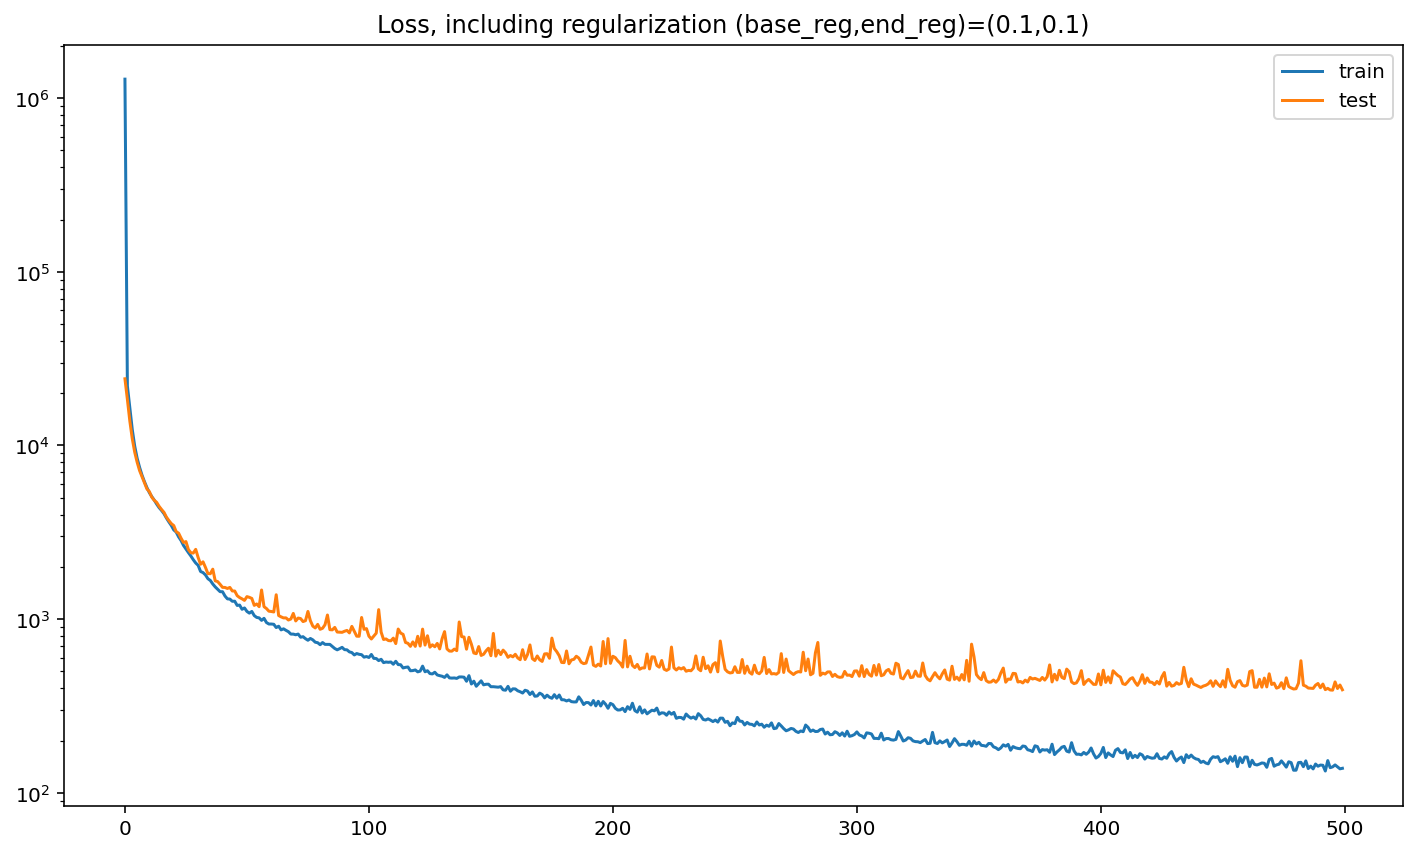

In [25]:
# Plot training and validation loss
if 1:
    plt.figure()
    if base_regularizer is None and end_regularizer is None:
        plt.title('Loss (no regularization)')
    else:
        plt.title(f'Loss, including regularization (base_reg,end_reg)=({base_reg},{end_reg})')
    plt.semilogy(history.history['loss'], label='train')
    plt.semilogy(history.history['val_loss'], label='test')
    plt.ylim((0, plt.ylim()[1]))  # Set lower ylim to 0
    plt.legend()
    plt.show()



In [27]:
# Calculate and print mean squared error
#if 1:
 #   gen_lab = generator.predict(dataG_train)
  #  MSE = np.square(np.subtract(labelsG_train, gen_lab)).mean()
   # print("Train Mean Squared Error: ", MSE)

  1/180 [..............................] - ETA: 1:30

 13/180 [=>............................] - ETA: 0s  

 25/180 [===>..........................] - ETA: 0s

 38/180 [=====>........................] - ETA: 0s

 59/180 [========>.....................] - ETA: 0s

 79/180 [============>.................] - ETA: 0s

 91/180 [==============>...............] - ETA: 0s

102/180 [================>.............] - ETA: 0s

121/180 [===================>..........] - ETA: 0s

125/180 [===================>..........] - ETA: 0s

143/180 [======================>.......] - ETA: 0s

158/180 [=========================>....] - ETA: 0s

166/180 [==========================>...] - ETA: 0s

180/180 [==============================] - 1s 5ms/step


Train Mean Squared Error:  94.091156


In [3]:
# Predict the values using the trained model for both training and test sets
predicted_train = generator.predict(dataG_train)
predicted_test = generator.predict(dataG_test)

# Calculate the Mean Absolute Error for the training set
mae_train = np.mean(np.abs(predicted_train - labelsG_train))

# Calculate the Mean Absolute Error for the test set
mae_test = np.mean(np.abs(predicted_test - labelsG_test))

# Print out the MAE for both sets
print("Train Mean Absolute Error: ", mae_train)
print("Test Mean Absolute Error: ", mae_test)


NameError: name 'generator' is not defined

  1/180 [..............................] - ETA: 2s

 17/180 [=>............................] - ETA: 0s

 45/180 [======>.......................] - ETA: 0s

 46/180 [======>.......................] - ETA: 0s

 74/180 [===========>..................] - ETA: 0s

103/180 [================>.............] - ETA: 0s

105/180 [================>.............] - ETA: 0s

132/180 [=====================>........] - ETA: 0s

161/180 [=========================>....] - ETA: 0s

164/180 [==========================>...] - ETA: 0s

180/180 [==============================] - 1s 3ms/step


Mean Squared Error:  41.799126


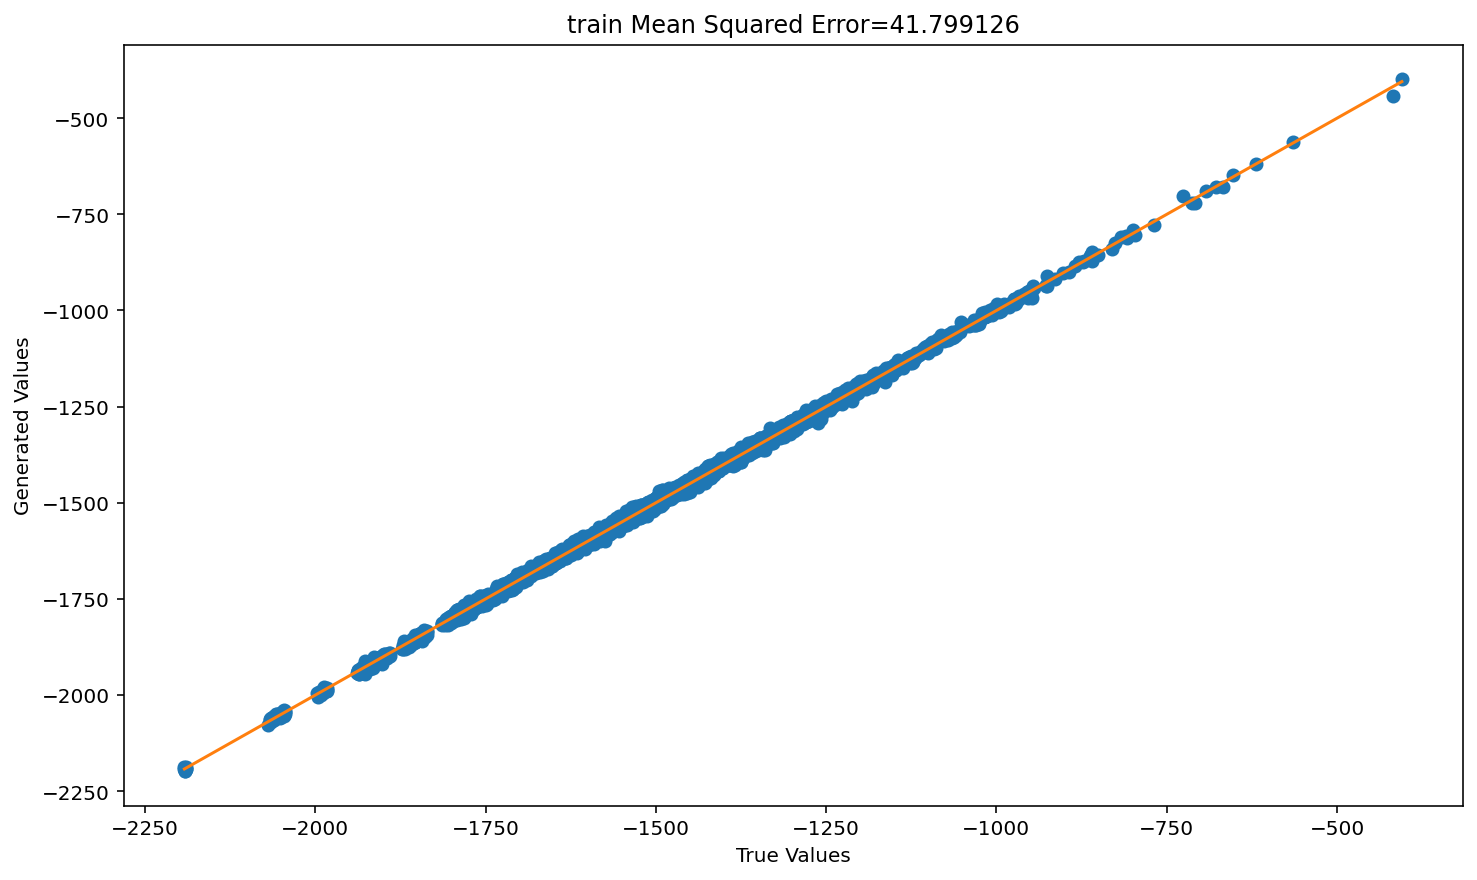

 1/45 [..............................] - ETA: 0s

27/45 [=================>............] - ETA: 0s

45/45 [==============================] - 0s 3ms/step


Mean Squared Error:  308.03458


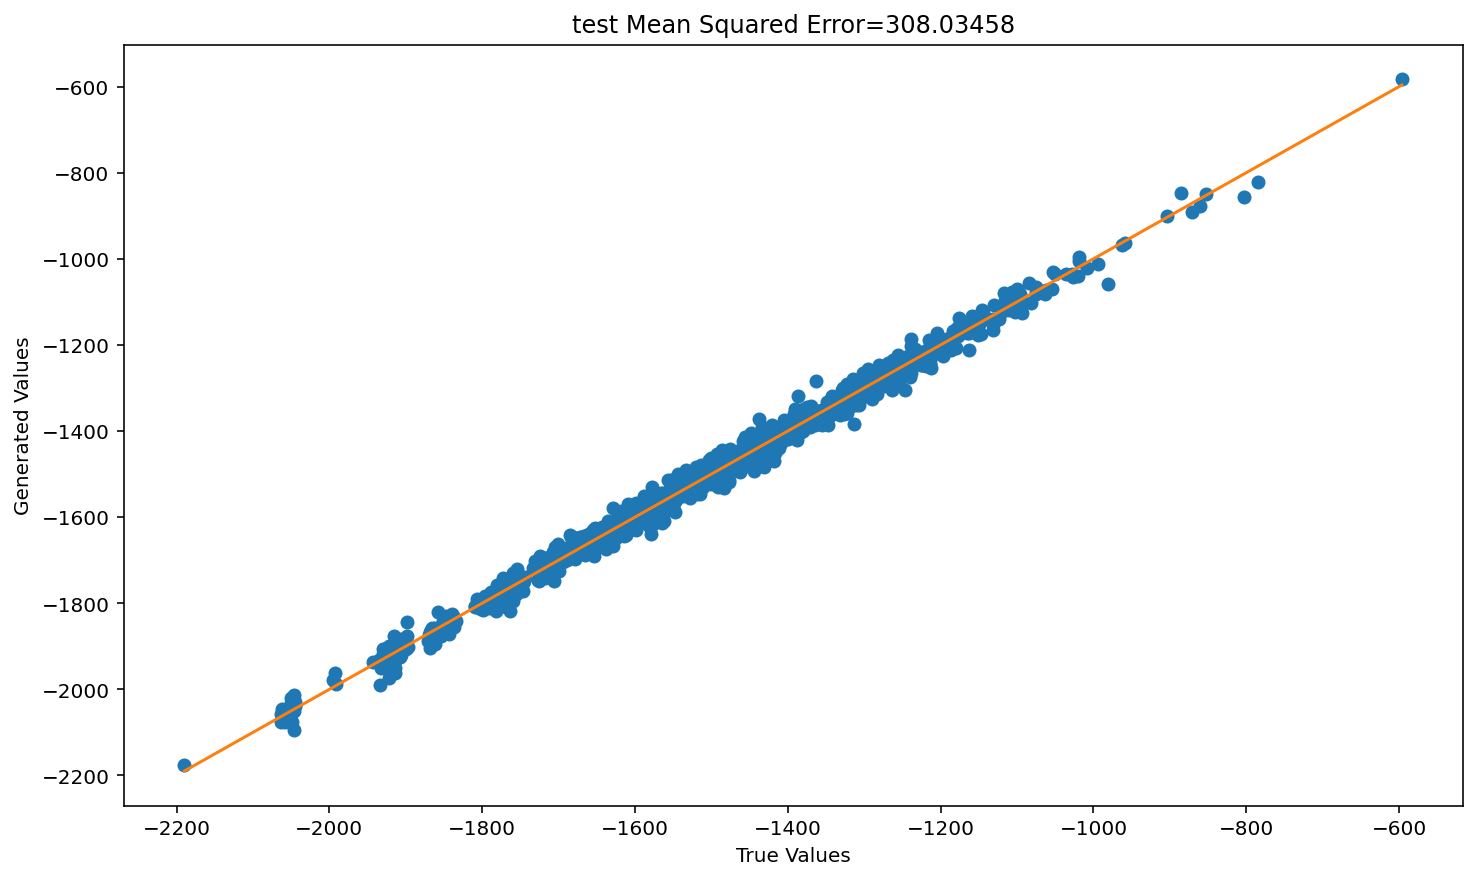

In [27]:
doresidual = False
legend=None
PvT_plot(generator,dataG_train,labelsG_train,title='train',doresidual=doresidual,legend=legend)
PvT_plot(generator,dataG_test,labelsG_test,title='test',doresidual=doresidual,legend=legend)